In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/brain tumor detection/archive.zip" -d "/content/drive/MyDrive/Colab Notebooks/brain tumor detection/data"

Archive:  /content/drive/MyDrive/Colab Notebooks/brain tumor detection/archive.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/brain tumor detection/data/brain_tumor_dataset/no/1 no.jpeg  
  inflating: /content/drive/MyDrive/Colab Notebooks/brain tumor detection/data/brain_tumor_dataset/no/10 no.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/brain tumor detection/data/brain_tumor_dataset/no/11 no.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/brain tumor detection/data/brain_tumor_dataset/no/12 no.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/brain tumor detection/data/brain_tumor_dataset/no/13 no.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/brain tumor detection/data/brain_tumor_dataset/no/14 no.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/brain tumor detection/data/brain_tumor_dataset/no/15 no.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/brain tumor detection/data/brain_tumor_dataset/no/17 no.jpg  
  inf

In [16]:
from IPython.display import clear_output
import imutils
clear_output()
# import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50

In [17]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [18]:
path = '/content/drive/MyDrive/Colab Notebooks/brain tumor detection/data'

In [ ]:
!apt-get install tree
import os


os.mkdir(path+'/TRAIN')
os.mkdir(path+'/TEST')
os.mkdir(path+'/VAL')

os.mkdir(path+'/TRAIN/YES')
os.mkdir(path+'/TRAIN/NO') 

os.mkdir(path+'/TEST/YES')
os.mkdir(path+"/TEST/NO") 

os.mkdir(path+'/VAL/YES')
os.mkdir(path+'/VAL/NO') 

!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
.
├── drive
│   └── MyDrive
│       ├── Abc
│       ├── Colab
│       ├── Colab Notebooks
│       │   ├── Blood Cell Detection
│       │   │   └── dataset
│       │   │       ├── dataset2-master
│       │   │       │   └── images
│       │   │       │       ├── TEST
│       │   │       │       │   ├── EOSINOPHIL
│       │   │       │       │   ├── LYMPHOCYTE
│       │   │       │       │   ├── MONOCYTE
│       │   │       │       │   └── NEUTROPHIL
│       │   │       │       ├── TEST_SIMPLE
│       │   │       │       │   ├── EOSINOPHIL
│       │   │       │       │   ├── LYMPHOCYTE
│       │   │       │       │   ├── MONOCYTE
│       │   │       │       │   └── NEUTROPHIL
│       │   │       │       └── TRAIN
│       │   │       │           ├── EOSINOPHIL
│       │   │       │     

['no', 'yes']

In [ ]:
IMG_PATH = path +  '/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    print(CLASS)
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        print(IMG_NUM)
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, path +'/TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, path +'/TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, path +'/VAL/'+ CLASS.upper() + '/' + FILE_NAME)

no
98
yes
155


In [19]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [21]:
TRAIN_DIR = path + '/TRAIN/'
TEST_DIR = path +'/TEST/'
VAL_DIR = path + '/VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)


100%|██████████| 2/2 [00:00<00:00,  2.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



193 images loaded from /content/drive/MyDrive/Colab Notebooks/brain tumor detection/data/TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 41.04it/s]


10 images loaded from /content/drive/MyDrive/Colab Notebooks/brain tumor detection/data/TEST/ directory.


100%|██████████| 2/2 [00:00<00:00,  7.03it/s]

50 images loaded from /content/drive/MyDrive/Colab Notebooks/brain tumor detection/data/VAL/ directory.


In [ ]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
fig.show(renderer="colab")

In [22]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

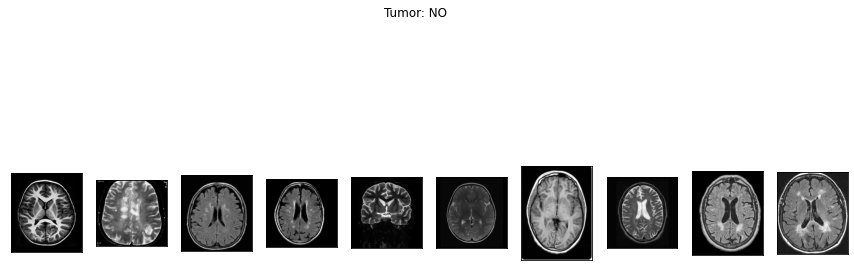

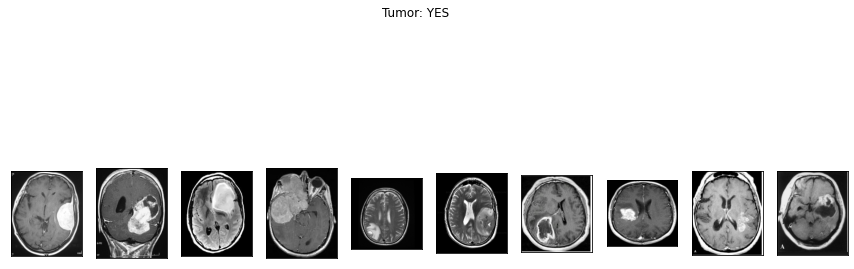

In [ ]:
plot_samples(X_train, y_train, labels, 10)

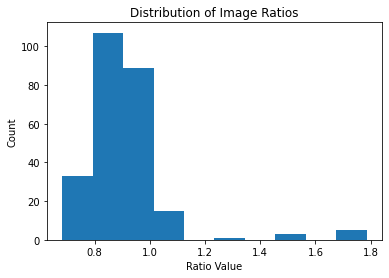

In [ ]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [23]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
img = cv2.imread(path + '/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()


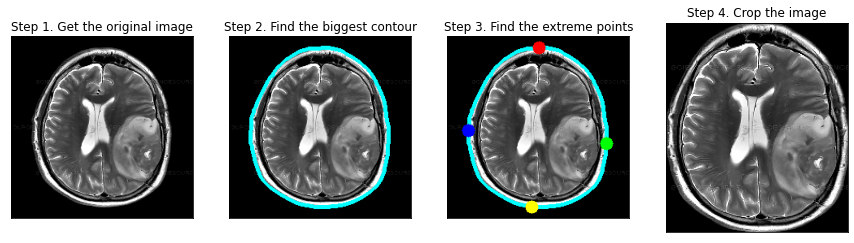

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



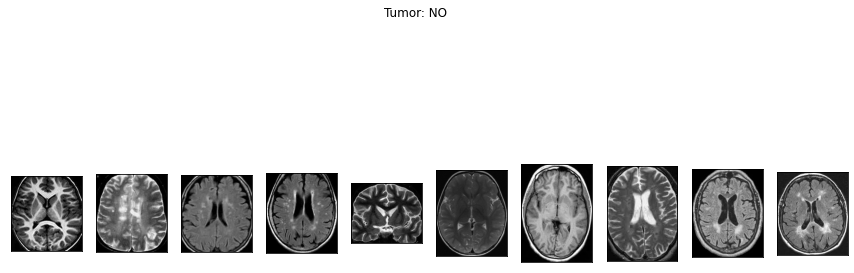

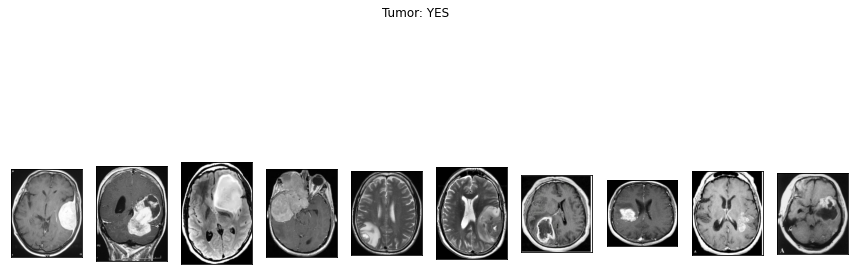

In [24]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

plot_samples(X_train_crop, y_train, labels, 10)


In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [25]:
crop_path =  '/content/drive/MyDrive/Colab Notebooks/brain tumor detection/cropped'

In [ ]:

os.mkdir(crop_path+'/TRAIN_CROP')
os.mkdir(crop_path+'/TEST_CROP')
os.mkdir(crop_path+'/VAL_CROP')

os.mkdir(crop_path+'/TRAIN_CROP/YES')
os.mkdir(crop_path+'/TRAIN_CROP/NO') 

os.mkdir(crop_path+'/TEST_CROP/YES')
os.mkdir(crop_path+"/TEST_CROP/NO") 

os.mkdir(crop_path+'/VAL_CROP/YES')
os.mkdir(crop_path+'/VAL_CROP/NO') 


In [ ]:
# saving new images to the folder

save_new_images(X_train_crop, y_train, folder_name= crop_path + '/TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name=crop_path + '/VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name=crop_path + '/TEST_CROP/')

In [26]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [27]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

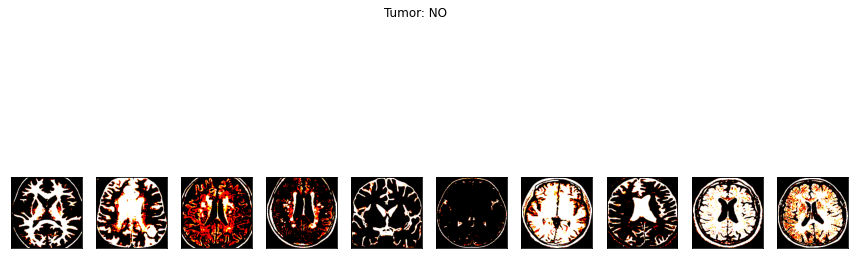

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

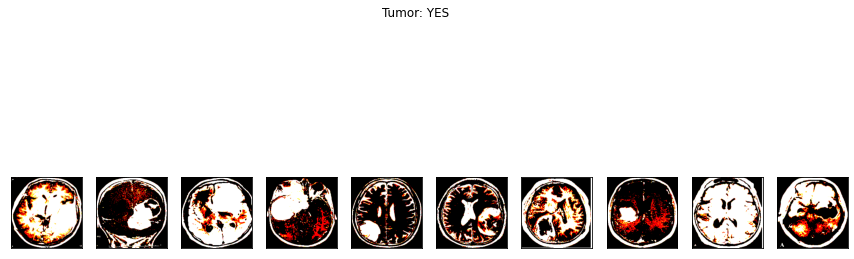

In [ ]:
plot_samples(X_train_prep, y_train, labels, 10)

In [35]:
TRAIN_DIR = crop_path + '/TRAIN_CROP/'
VAL_DIR = crop_path + '/VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


**VGG16**

In [29]:
# load base model

vgg = VGG16(
    include_top=False,
    weights="/content/drive/MyDrive/Colab Notebooks/brain tumor detection/baseline models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",
    input_shape=IMG_SIZE + (3,)

)

In [30]:
NUM_CLASSES = 1

vgg16 = Sequential()
vgg16.add(vgg)
vgg16.add(layers.Dropout(0.3))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg16.layers[0].trainable = False

vgg16.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)
vgg16.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])

vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [31]:
# visualize feature maps output from each block in the vgg model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
import matplotlib.pyplot as plt
from numpy import expand_dims




# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
# convert the image to an array
img = img_to_array(X_val_prep[43])
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		plt.figure(figsize=(64,64))
		for _ in range(square):
           

			# specify subplot and turn of axis
			ax = plt.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1], cmap='viridis')
			ix += 1
	# show the figure

        
	plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [37]:
import time

start = time.time()

vgg16_history = vgg16.fit(
    train_generator,
    steps_per_epoch=187,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=5,
)


end = time.time()
print(end - start)

Epoch 1/100
187/187 [==============================] - 4s 22ms/step - loss: 2.8031 - accuracy: 0.8824 - val_loss: 1.2343e-24 - val_accuracy: 1.0000
Epoch 2/100
187/187 [==============================] - 4s 22ms/step - loss: 2.9881 - accuracy: 0.8770 - val_loss: 2.3219e-07 - val_accuracy: 1.0000
Epoch 3/100
187/187 [==============================] - 4s 22ms/step - loss: 2.0394 - accuracy: 0.9037 - val_loss: 2.6269e-15 - val_accuracy: 1.0000
Epoch 4/100
187/187 [==============================] - 4s 22ms/step - loss: 3.3040 - accuracy: 0.8824 - val_loss: 2.3652e-09 - val_accuracy: 1.0000
Epoch 5/100
187/187 [==============================] - 4s 22ms/step - loss: 2.2038 - accuracy: 0.8877 - val_loss: 4.5299 - val_accuracy: 0.5000
Epoch 6/100
187/187 [==============================] - 4s 22ms/step - loss: 2.8641 - accuracy: 0.9144 - val_loss: 2.8751e-12 - val_accuracy: 1.0000
Epoch 7/100
187/187 [==============================] - 4s 22ms/step - loss: 3.3100 - accuracy: 0.8449 - val_loss: 3.

In [38]:
# validate on val set
predictions = vgg16.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = vgg16.evaluate(X_val_prep, y_val, verbose=0)
_, test_acc = vgg16.evaluate(X_test_prep, y_test, verbose=0)

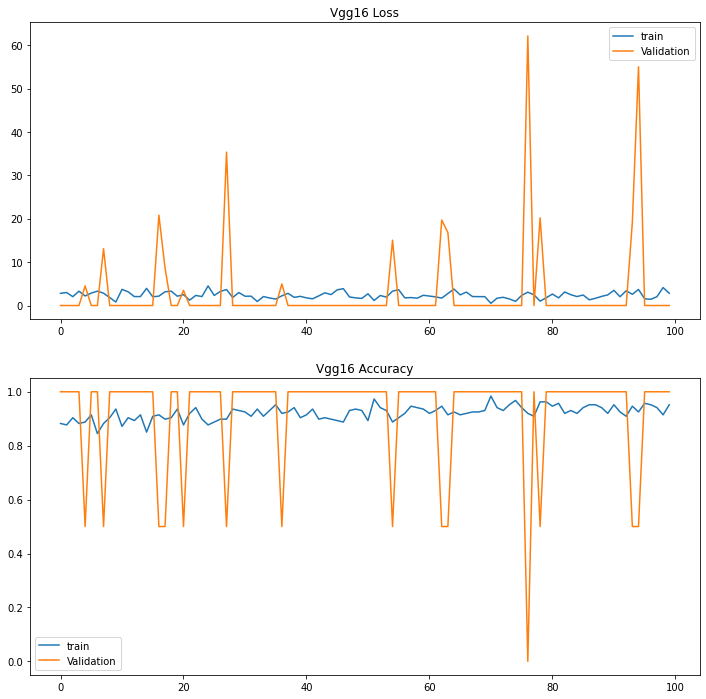

In [42]:
plt.figure(figsize=(12,12))
# plot loss during training
plt.subplot(211)
plt.title('Vgg16 Loss')
plt.plot(vgg16_history.history['loss'], label='train')
plt.plot(vgg16_history.history['val_loss'], label='Validation')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Vgg16 Accuracy')
plt.plot(vgg16_history.history['accuracy'], label='train')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

In [43]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.900, Test: 0.900


In [44]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

In [45]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.900000
Precision: 0.833333
Recall: 1.000000
F1 score: 0.909091


In [46]:
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)


Cohens kappa: 0.800000
ROC AUC: 0.900000
[[4 1]
 [0 5]]


**inceptionV3**

In [47]:
# load base model
InceptionV3_weight_path = '/content/drive/MyDrive/Colab Notebooks/brain tumor detection/baseline models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inceptionV3 = InceptionV3(
     weights=InceptionV3_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [48]:
NUM_CLASSES = 1

inception_v3 = Sequential()
inception_v3.add(inceptionV3)
inception_v3.add(layers.Dropout(0.3))
inception_v3.add(layers.Flatten())
inception_v3.add(layers.Dropout(0.5))
inception_v3.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

inception_v3.layers[0].trainable = False

inception_v3.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

inception_v3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_3 (Dropout)         (None, 51200)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51201     
                                                                 
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau


In [54]:
# Implement callbacks 
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/brain tumor detection/saved models/inception.hdf5', save_best_only=True, save_weights_only=False)
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 5, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

In [56]:
start = time.time()

inception_v3_history = inception_v3.fit_generator(
    train_generator,
    steps_per_epoch=187,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint,learning_rate_reduction],
    validation_steps=2,
)

end = time.time()
print(end - start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/100
187/187 [==============================] - 6s 34ms/step - loss: 8.7914 - accuracy: 0.6364 - val_loss: 6.5601 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 2/100
187/187 [==============================] - 7s 38ms/step - loss: 9.4157 - accuracy: 0.6791 - val_loss: 2.8519 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 3/100
187/187 [==============================] - 6s 32ms/step - loss: 10.6067 - accuracy: 0.6791 - val_loss: 3.6173 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 4/100
187/187 [==============================] - 7s 39ms/step - loss: 8.7992 - accuracy: 0.6417 - val_loss: 2.5124 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 5/100
187/187 [==============================] - 6s 32ms/step - loss: 12.2913 - accuracy: 0.7005 - val_loss: 3.9415 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 6/100
187/187 [==============================] - 6s 33ms/step - loss: 12.0630 - accuracy: 0.6471 - val_loss: 5.4868 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 7/100
187/187 [==========

In [57]:
# validate on val set
predictions = inception_v3.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = inception_v3.evaluate(X_val_prep, y_val, verbose=0)
_, test_acc = inception_v3.evaluate(X_test_prep, y_test, verbose=0)

In [58]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.700, Test: 0.900


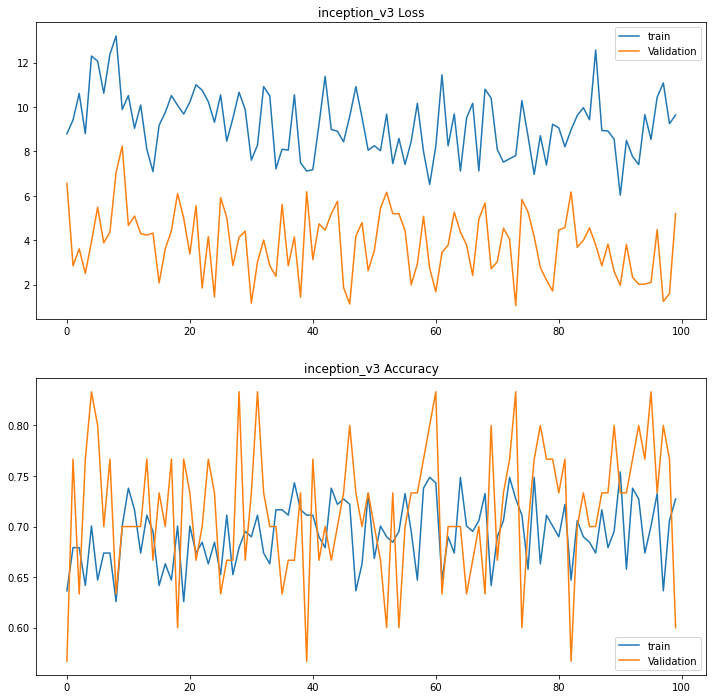

In [59]:

plt.figure(figsize=(12,12))
# plot loss during training
plt.subplot(211)
plt.title('inception_v3 Loss')
plt.plot(inception_v3_history.history['loss'], label='train')
plt.plot(inception_v3_history.history['val_loss'], label='Validation')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('inception_v3 Accuracy')
plt.plot(inception_v3_history.history['accuracy'], label='train')
plt.plot(inception_v3_history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

In [60]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.900000
Precision: 1.000000
Recall: 0.800000
F1 score: 0.888889


In [61]:
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)


Cohens kappa: 0.800000
ROC AUC: 0.900000
[[5 0]
 [1 4]]


Generating plots...
Generating plots...
Val Accuracy = 0.90
Generating plots...
Generating plots...
Val Accuracy = 0.70


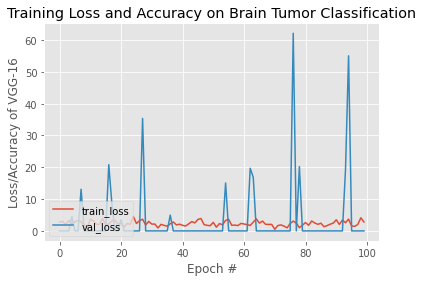

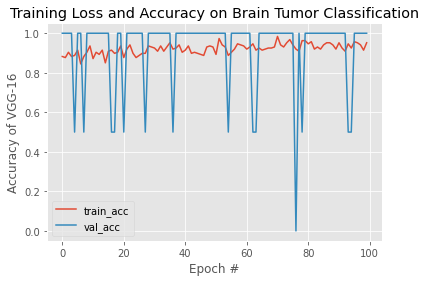

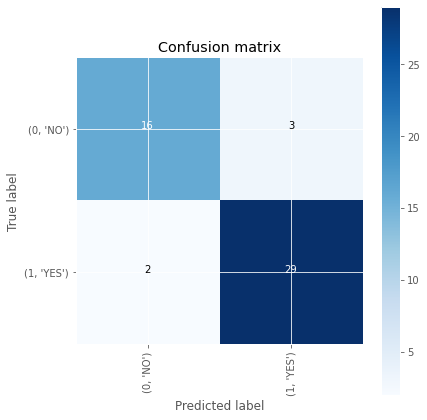

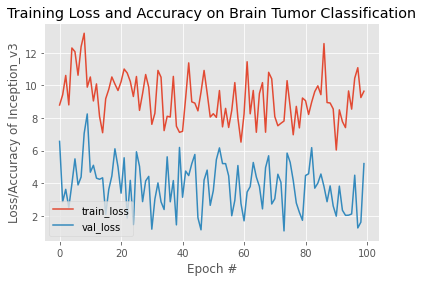

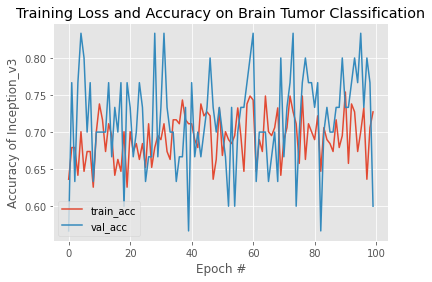

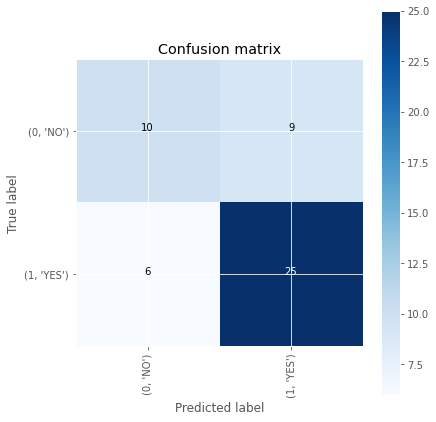

In [68]:
def ModelGraphTrainngSummary(history,N,model_name):
    # set the matplotlib backend so figures can be saved in the background
    # plot the training loss and accuracy
    import sys
    import matplotlib
    print("Generating plots...")
    sys.stdout.flush()
    matplotlib.use("Agg")
    matplotlib.pyplot.style.use("ggplot")
    matplotlib.pyplot.figure()
    matplotlib.pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["acc"], label="train_acc")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
    matplotlib.pyplot.title("Training Loss and Accuracy on Brain Tumor Classification")
    matplotlib.pyplot.xlabel("Epoch #")
    matplotlib.pyplot.ylabel("Loss/Accuracy of "+model_name)
    matplotlib.pyplot.legend(loc="lower left")
    # matplotlib.pyplot.savefig("plot.png")


def ModelGraphTrainngSummaryAcc(history,N,model_name):
    # set the matplotlib backend so figures can be saved in the background
    # plot the training loss and accuracy
    import sys
    import matplotlib
    print("Generating plots...")
    sys.stdout.flush()
    matplotlib.use("Agg")
    matplotlib.pyplot.style.use("ggplot")
    matplotlib.pyplot.figure()
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
    matplotlib.pyplot.title("Training Loss and Accuracy on Brain Tumor Classification")
    matplotlib.pyplot.xlabel("Epoch #")
    matplotlib.pyplot.ylabel("Accuracy of "+ model_name)
    matplotlib.pyplot.legend(loc="lower left")
    matplotlib.pyplot.savefig("plot.png")
for x_model in [{'name':'VGG-16','history':vgg16_history,'model':vgg16},
                {'name':'Inception_v3','history':inception_v3_history,'model':inception_v3}]:
    ModelGraphTrainngSummary(x_model['history'],100,x_model['name'])
    ModelGraphTrainngSummaryAcc(x_model['history'],100,x_model['name'])
    
    # validate on val set
    predictions = x_model['model'].predict(X_val_prep)
    predictions = [1 if x>0.5 else 0 for x in predictions]

    accuracy = accuracy_score(y_val, predictions)
    print('Val Accuracy = %.2f' % accuracy)

    confusion_mtx = confusion_matrix(y_val, predictions) 
    cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)